In [2]:
## Welcome to the interactive jupyter notbook we use for plotting.
## We assume that you have collected your traffic and analyzed it with the corresponding
## plugins and now are in possesion of a consent.json and noconsent.json representing
## the observed and analyze taffic giving and not giving consent
## Go through the notebook cell by cell and after each function definitions you will
## encounter a cell executing a previously defined function with a comment telling you what 
## data and for which section in the paper it generates output for.

from matplotlib import pyplot
from matplotlib import pyplot as plt
from matplotlib import rc
from math import floor, trunc, sqrt
import seaborn as sns
import json as js
import random
import numpy as np
import statistics
default_figsize_x, default_figsize_y = plt.rcParams["figure.figsize"]

# the below code unifies and beautifies our graphs
sns.reset_defaults()
sns.set_theme(context="paper", font_scale=1.1, palette="colorblind")
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'size': 18})
plt.ion()

In [3]:
# utility function to read in jsons generated by our plotalyzer plugin
def readJson(file):
    with open(file,"r") as f:
        return js.load(f)

# utility function to generated LaTeX commands making it easier to update macros
def displayCommand(command,value):
    print("\\newcommand{\\" + command + "}{" + str(value) + "}")

In [39]:
# reading in our plugin results
consent_unfiltered = readJson("./consent.json")
noconsent_unfiltered = readJson("./noconsent.json")

In [64]:
# we want to ignore those extracted data points as they are not informative
# obsfuscated/deobfuscated are custom as AppsFlyer and AppLovin conduct some obfuscation we were not always able to break
# we only observed a single SDK with an IAB string contained which was not informative
# we remove Longitude, Latitude as the data points we obtained were pointing to a completely wrong location and thus cannot be sure to have meaning/be intended to represent the user location
ignoreData = ["OBFUSCATED","DEOBFUSCATED", "IAB_STRING", "LONGITUDE","LATITUDE"]
def filterResults(inputData):
    for app, analysis in inputData["appAnalysis"].items():
        for func, domains in analysis.items():
            for domain, paths in domains["domains"].items():
                for path, data in paths.items():
                    filteredPii = list()
                    for pii in data["pii"]:
                        # if we want to ignore the data or the data is missing we do not want to keep this data point to ensure that we do not count or plot them later on
                        if (pii["PII"] in ignoreData) or ("#MISSING@" in pii["value"] and not pii["value"].strip() == ""):
                            pass
                        else:
                            filteredPii.append(pii)
                    data["pii"] = filteredPii
    return inputData

# apply our filtering to the result json and continue working with the filtered results where appropriate
consent = filterResults(consent_unfiltered)
assert consent != None
noconsent = filterResults(noconsent_unfiltered)
assert noconsent != None

In [43]:
# Here we translate the App names into their proper Vendor name, the operating system, and the type of SDK they are
def translateAppName(name) :
    if name == "de.tubs.cs.ias.firebaseanalyticstestbed:NA@android": #1
        return "Firebase Analytics","Android", "analytics"
    if name == "MeaCulpa.Firebase-iOS:NA@ios": 
        return "Firebase Analytics", "iOS", "analytics"
    if name == "de.tubs.cs.ias.flutebe:NA@android": #2
        return "Flurry", "Android", "analytics"
    if name == "de.tubs.cs.ias.FlurryTestbed:NA@ios":
        return "Flurry", "iOS", "analytics"
    if name == "de.tubs.cs.ias.ausschlag:NA@android": #3
        return "Amplitude", "Android", "analytics"
    if name == "de.tubs.cs.ias.AmplitudeTestbed:NA@ios":
        return "Amplitude", "iOS", "analytics"
    if name == "de.tubs.cs.ias.admob:NA@android": #4
        return "Google AdMob", "Android", "advertisement"
    if name == "MeaCulpa.AdMob-iOS:NA@ios":
        return "Google AdMob", "iOS", "advertisement"
    if name == "de.tubs.cs.ias.unity3dandroidtestbed:NA@android": #5
        return "Unity3d", "Android", "advertisement"
    if name == "de.tubs.cs.ias.Unity3DTestbed:NA@ios":
        return "Unity3d", "iOS", "advertisement"
    if name == "MeaCulpa.FaBoAnalytics-iOS:NA@ios": #6
        return "Meta App Events", "iOS", "analytics"
    if name == "de.tubs.cs.ias.gba:NA@android":
        return "Meta App Events", "Android", "analytics"
    if name == "de.tubs.cs.ias.AppLovinTest:NA@ios": #7
        return "AppLovin", "iOS", "advertisement"
    if name == "de.tubs.cs.ias.applovin:NA@android":
        return "AppLovin", "Android", "advertisement"
    if name == "de.tubs.cs.ias.fly:NA@android": #8
        return "AppsFlyer", "Android", "advertisement"
    if name == "MeaCulpa.AFiOS:NA@ios":
        return "AppsFlyer", "iOS", "advertisement"
    if name == "de.tubs.cs.ias.fbadstestbed:NA@android": #9
        return "Meta Audience Network", "Android", "advertisement"
    if name == "de.tubs.cs.ias.FBAdsTestbed:NA@ios":
        return "Meta Audience Network", "iOS", "advertisement"
    if name == "de.tubs.cs.ias.vappp:NA@android": #10
        return "Vungle", "Android", "advertisement"
    if name == "de.tubs.cs.ias.VungleTestbed:NA@ios":
        return "Vungle", "iOS", "advertisement"
    raise Exception("I do not known " + name)

# this function pairs up our iOS and Android measurements for easier plotting and analysis later on
def getAnalyzedAppPairs(analysis) :
    ret = {}
    for appName,values in analysis.items():
        name, os, _ = translateAppName(appName)
        if name in ret:
            pass
        else:
            ret[name] = {"Android" : None, "iOS" : None}
        ret[name][os] = values
    return ret

In [44]:
consent_paired = getAnalyzedAppPairs(consent["appAnalysis"])
noconsent_paired = getAnalyzedAppPairs(noconsent["appAnalysis"])

In [45]:
# Basic Request Metrics

# utility command to create LaTeX macros for our empirical results to update our numbers consistently when required
def getNumbersMacro(name, value, number=True):
    if number:
        return "\\newcommand{\\" + name + "}{\\empirical{\\num{" + str(value) + "}}}"
    else:
        return "\\newcommand{\\" + name + "}{\\empirical{" + str(value) + "}}"


# function to gather basic request metric information for both iOS and Android
def getBasicRequestMetrics(input):
    # the metric variables for Android
    requestsAndroidSucc = 0
    requestsAndroidFail = 0
    requestsAndroidMax = 0
    requestsAndroidMaxSdk = ""
    requestsAndroidMin = 10000
    requestsAndroidMinSDK = ""
    # the metric variables for iOS
    requestsIOSSucc = 0
    requestsIOSFail = 0
    requestsIOSMax = 0
    requestsIOSMaxSDK = ""
    requestsIOSMin = 1000
    requestsIOSMinSDK = ""
    # iterate over all App pairs
    for name, pair in input.items():
        # the handle for the Android app
        android = pair["Android"]
        # the handle for the iOS app
        iOS = pair["iOS"]
        # keep track of the per SDK requests
        sumAndroid = 0
        sumIOS = 0
        # go over all phases on android
        for phase, domains in android.items():
            # we had an initial nothing phase to make life easier for the PI, we do not want to analyze this phase however
            if phase == "NOTHING":
                continue
            # go over all observed domains on android
            for _, paths in domains["domains"].items():
                # go over all observed paths on android, if domain and path are equal it is the same endpoint
                for _, data in paths.items():
                    # increment the amount of successfully intercepted requests
                    requestsAndroidSucc += data["success"]
                    # increment the amount of failed intercepted android requests (SSL pinning be damned)
                    requestsAndroidFail += data["overall"] - data["success"]
                    # increment the total amount of intercepted android requests on this SDK
                    sumAndroid += data["overall"]
        # go over all phases on iOS
        for phase, domains in iOS.items():
            # we had an initial nothing phase to make life easier for the PI, we do not want to analyze this phase however
            if phase == "NOTHING":
                continue
            # go over all observed domains on iOS
            for _, paths in domains["domains"].items():
                # go over all observed paths on android, if domain and path are equal it is the same endpoint
                for _, data in paths.items():
                    # increment the amount of successfully intercepted requests
                    requestsIOSSucc += data["success"]
                    # increment the amount of failed intercepted requests (didn't happen on iOS, thanks to checkra1n)
                    requestsIOSFail += data["overall"] - data["success"]
                    # increment the total amount of intercepted requests on this SDK
                    sumIOS += data["overall"]
        # update the max if the current SDK did the most requests on Android
        if sumAndroid > requestsAndroidMax:
            requestsAndroidMax = sumAndroid
            requestsAndroidMaxSDK = name
        # update the min if the current SDK did the most requests on Android
        if sumAndroid < requestsAndroidMin:
            requestsAndroidMin = sumAndroid
            requestsAndroidMinSDK = name
        # update the max if the current SDK did the most requests on iOS
        if sumIOS > requestsIOSMax:
            requestsIOSMax = sumIOS
            requestsIOSMaxSDK = name
        # update the min if the current SDK did the most requests on iOS
        if sumIOS < requestsIOSMin:
            requestsIOSMin = sumIOS
            requestsIOSMinSDK = name

    # calculate the total amount of requests on Android and iOS
    requestsAndroid = requestsAndroidSucc + requestsAndroidFail
    requestsIOS = requestsIOSSucc + requestsIOSFail
    # calculate the total amount of successfull and failed requests on Android and iOS
    requestsSucc = requestsAndroidSucc + requestsIOSSucc
    requestsFail = requestsAndroidFail + requestsIOSFail
    # start printing our latex macros, i.e., results
    print(getNumbersMacro("overallRequests", requestsAndroid + requestsIOS))
    print(getNumbersMacro("requestsSucc", requestsAndroidSucc + requestsIOSSucc))
    print(getNumbersMacro("requestsFail", requestsAndroidFail + requestsIOSFail))
    # Android
    print(getNumbersMacro("requestsAndroid", requestsAndroid))
    print(getNumbersMacro("requestsAndroidSucc", requestsAndroidSucc))
    print(getNumbersMacro("requestsAndroidFail", requestsAndroidFail))
    print(getNumbersMacro("requestsAndroidAvg", requestsAndroid / len(input.keys())))
    print(getNumbersMacro("requestsAndroidMaxSDK",requestsAndroidMaxSDK))
    print(getNumbersMacro("requestsAndroidMaxSDKCount",requestsAndroidMax))
    print(getNumbersMacro("requestsAndroidMinSDK",requestsAndroidMinSDK))
    print(getNumbersMacro("requestsAndroidMinSDKCount",requestsAndroidMin))
    # iOS
    print(getNumbersMacro("requestsIOS", requestsIOS))
    print(getNumbersMacro("requestsIOSSucc", requestsIOSSucc))
    print(getNumbersMacro("requestsIOSFail", requestsIOSFail))
    print(getNumbersMacro("requestsIOSAvg", requestsIOS / len(input.keys())))
    print(getNumbersMacro("requestsIOSMaxSDK",requestsIOSMaxSDK))
    print(getNumbersMacro("requestsIOSMaxSDKCount",requestsIOSMax))
    print(getNumbersMacro("requestsIOSMinSDK",requestsIOSMinSDK))
    print(getNumbersMacro("requestsIOSMinSDKCount",requestsIOSMin))


# this function calculates the average, standard deviation (sigma), and mean of a given list of numbers
def getAvgSigMean(list):
    list.sort()
    theMean = list[trunc(len(list)/2)]
    theSum = sum(list)
    theAverage = theSum / len(list)
    variance = 0
    for elem in list:
        variance += (elem - theMean) * (elem - theMean)
    sigma = sqrt(variance / len(list))
    return theAverage, sigma, theMean

    
# this function returns the min (respective max) value for the provided phase dictionary
def getMinMaxPhase(phaseCount, min=True):
    comp = 1000 if min else 0
    phase = "" 
    for name, value in phaseCount.items():
        if (value < comp and min) or (value > comp and not min):
            comp = value
            phase = name
    return phase


# analyzes the different phases across Android and iOS to understand the total, min, max for each SDK and phase
def getPhaseRequestMetrics(input):
    # gather the total amount of requests per phase
    requestsPerPhaseAndroid       = { "CREATE_OBJECT" : 0, "CONSENT" : 0, "INIT" : 0, "BASIC_FUNC" : 0}
    requestsPerPhaseIOS           = { "CREATE_OBJECT" : 0, "CONSENT" : 0, "INIT" : 0, "BASIC_FUNC" : 0}
    # gather the maximum amount of requests per phase and the corresponding SDK
    maxRequestsPerPhaseAndroid    = { "CREATE_OBJECT" : 0, "CONSENT" : 0, "INIT" : 0, "BASIC_FUNC" : 0} 
    maxRequestsPerPhaseAndroidSDK = { "CREATE_OBJECT" : "", "CONSENT" : "", "INIT" : "", "BASIC_FUNC" : ""}
    maxRequestsPerPhaseIOS        = { "CREATE_OBJECT" : 0, "CONSENT" : 0, "INIT" : 0, "BASIC_FUNC" : 0}
    maxRequestsPerPhaseIOSSDK     = { "CREATE_OBJECT" : "", "CONSENT" : "", "INIT" : "", "BASIC_FUNC" : ""}
    # gather the minimum amount of requests per phase and the corresponding SDK
    minRequestsPerPhaseAndroid    = { "CREATE_OBJECT" : 1000, "CONSENT" : 1000, "INIT" : 1000, "BASIC_FUNC" : 1000}
    minRequestsPerPhaseAndroidSDK = { "CREATE_OBJECT" : "", "CONSENT" : "", "INIT" : "", "BASIC_FUNC" : ""}
    minRequestsPerPhaseIOS        = { "CREATE_OBJECT" : 1000, "CONSENT" : 1000, "INIT" : 1000, "BASIC_FUNC" : 1000}
    minRequestsPerPhaseIOSSDK     = { "CREATE_OBJECT" : "", "CONSENT" : "", "INIT" : "", "BASIC_FUNC" : "" }
    # go over all apps
    for name, pair in input.items():
        # handle for the android analysis
        android = pair["Android"]
        # handle for the iOS analysis
        iOS = pair["iOS"]
        # go over all phases in android
        for function, domains in android.items():
            # we sometimes required extending the collection time manually to counteract caching, but the phase is equivalent to BASIC_FUNC
            if function == "BASIC_FUNC_INF":
                # thus we make our life easier by just seting this here
                function = "BASIC_FUNC"
            # we had an initial nothing phase to make life easier for the PI, we do not want to analyze this phase however
            if function != "NOTHING":
                # keep track of the total amount of requests
                sumAndroid = 0
                # go over all observed domains
                for _, paths in domains["domains"].items():
                    # go over all observed paths
                    for _, data in paths.items():
                        # add up the overall amount of observed requests here
                        sumAndroid += data["overall"]
                # ad the sum to the overall requests for this phase
                requestsPerPhaseAndroid[function] += sumAndroid
                # if the current sum is larger than the current max phase
                if sumAndroid > maxRequestsPerPhaseAndroid[function]:
                    # update the new max
                    maxRequestsPerPhaseAndroid[function] = sumAndroid
                    maxRequestsPerPhaseAndroidSDK[function] = name
                # if the current sum is smaller than the current min phase
                if sumAndroid < minRequestsPerPhaseAndroid[function]:
                    # update the new min
                    minRequestsPerPhaseAndroid[function] = sumAndroid
                    minRequestsPerPhaseAndroidSDK[function] = name
        # go over all phases in iOS
        for function, domains in iOS.items():
            # we sometimes required extending the collection time manually to counteract caching, but the phase is equivalent to BASIC_FUNC
            if function == "BASIC_FUNC_INF":
                # thus we make our life easier by just setting this here
                function = "BASIC_FUNC"
            # we had an initial nothing phase to make life easier for the PI, we do not want to analyze this phase however
            if function != "NOTHING":
                # keep track of the total amount of requests
                sumIOS = 0
                # go over all observed domains
                for _, paths in domains["domains"].items():
                    # go over all observed paths
                    for _, data in paths.items():
                        # add up the overall amount of observed requests here
                        sumIOS += data["overall"]
                # ad the sum to the overall requests for this phase
                requestsPerPhaseIOS[function] += sumIOS
                # if the current sum is larger than the current max phase
                if sumIOS > maxRequestsPerPhaseIOS[function]:
                    # update the new max
                    maxRequestsPerPhaseIOS[function] = sumIOS
                    maxRequestsPerPhaseIOSSDK[function] = name
                # if the current sum is smaller than the current min phase
                if sumIOS < minRequestsPerPhaseIOS[function]:
                    # update the new min
                    minRequestsPerPhaseIOS[function] = sumIOS
                    minRequestsPerPhaseIOSSDK[function] = name

    # retrieve the statistical properties across all phases
    avgRequestAndroid, sigmaRequestAndroid, _ = getAvgSigMean([x for x in requestsPerPhaseAndroid.values()])
    avgRequestIOS, sigmaRequestIOS, _ = getAvgSigMean([x for x in requestsPerPhaseIOS.values()])

    # get the maximum phase and the corresponding SDK
    maxPhaseAndroid = getMinMaxPhase(maxRequestsPerPhaseAndroid,min=False)
    maxPhaseAndroidCount = maxRequestsPerPhaseAndroid[maxPhaseAndroid]
    maxPhaseAndroidSDK = maxRequestsPerPhaseAndroid[maxPhaseAndroid]
    maxPhaseIOS = getMinMaxPhase(maxRequestsPerPhaseIOS,min=False)
    maxPhaseIOSCount = maxRequestsPerPhaseIOS[maxPhaseIOS]
    maxPhaseIOSSDK = maxRequestsPerPhaseIOS[maxPhaseIOS]
    # get the minimum phase and the corresponding SDK
    minPhaseAndroid = getMinMaxPhase(minRequestsPerPhaseAndroid)
    minPhaseAndroidCount = minRequestsPerPhaseAndroid[maxPhaseAndroid]
    minPhaseAndroidSDK = minRequestsPerPhaseAndroid[maxPhaseAndroid]
    minPhaseIOS = getMinMaxPhase(minRequestsPerPhaseIOS)
    minPhaseIOSCount = minRequestsPerPhaseIOS[maxPhaseIOS]
    minPhaseIOSSDK = minRequestsPerPhaseIOS[maxPhaseIOS]

    # start printing our latex macros, i.e., results

    # Android
    print(getNumbersMacro("phaseAvgRequestsAndroid",avgRequestAndroid))
    print(getNumbersMacro("phaseSigmaRequestsAndroid",sigmaRequestAndroid))
    print(getNumbersMacro("phaseMaxRequestsAndroid",maxPhaseAndroid,number=False))
    print(getNumbersMacro("phaseMaxRequestsAndroidSDK",maxPhaseAndroidSDK,number=False))
    print(getNumbersMacro("phaseMaxRequestsAndroidCount",maxPhaseAndroidCount,number=True))
    print(getNumbersMacro("phaseMinRequestsAndroid",minPhaseAndroid,number=False))
    print(getNumbersMacro("phaseMinRequestsAndroidSDK",minPhaseAndroidSDK,number=False))
    print(getNumbersMacro("phaseMinRequestsAndroidCount",minPhaseAndroidCount,number=True))
    # iOS
    print(getNumbersMacro("phaseAvgRequestsIOS",avgRequestIOS))
    print(getNumbersMacro("phaseSigmaRequestsIOS",sigmaRequestIOS))
    print(getNumbersMacro("phaseMaxRequestsIOS",maxPhaseIOS,number=False))
    print(getNumbersMacro("phaseMaxRequestsIOSSDK",maxPhaseIOSSDK,number=False))
    print(getNumbersMacro("phaseMaxRequestsIOSCount",maxPhaseIOSCount,number=True))
    print(getNumbersMacro("phaseMinRequestsIOS",minPhaseIOS,number=False))
    print(getNumbersMacro("phaseMinRequestsIOSSDK",minPhaseIOSSDK,number=False))
    print(getNumbersMacro("phaseMinRequestsIOSCount",minPhaseIOSCount,number=True))
            

In [46]:
# Here are the results reported in 4.3.1 and Table 5. The remainging values are calculated based on Table 6 whose numbers are generated later on
print("%%%%% Traffic Collection Request Analysis Results %%%%%")
print("%%%%% Across SDKS %%%%%")
getBasicRequestMetrics(consent_paired)
print()
print("%%%%% Across Phases %%%%%")
getPhaseRequestMetrics(consent_paired)

%%%%% Traffic Collection Request Analysis Results %%%%%
%%%%% Across SDKS %%%%%
\newcommand{\overallRequests}{\empirical{\num{199}}}
\newcommand{\requestsSucc}{\empirical{\num{197}}}
\newcommand{\requestsFail}{\empirical{\num{2}}}
\newcommand{\requestsAndroid}{\empirical{\num{76}}}
\newcommand{\requestsAndroidSucc}{\empirical{\num{74}}}
\newcommand{\requestsAndroidFail}{\empirical{\num{2}}}
\newcommand{\requestsAndroidAvg}{\empirical{\num{7.6}}}
\newcommand{\requestsAndroidMaxSDK}{\empirical{\num{AppLovin}}}
\newcommand{\requestsAndroidMaxSDKCount}{\empirical{\num{33}}}
\newcommand{\requestsAndroidMinSDK}{\empirical{\num{Amplitude}}}
\newcommand{\requestsAndroidMinSDKCount}{\empirical{\num{1}}}
\newcommand{\requestsIOS}{\empirical{\num{123}}}
\newcommand{\requestsIOSSucc}{\empirical{\num{123}}}
\newcommand{\requestsIOSFail}{\empirical{\num{0}}}
\newcommand{\requestsIOSAvg}{\empirical{\num{12.3}}}
\newcommand{\requestsIOSMaxSDK}{\empirical{\num{AppLovin}}}
\newcommand{\requestsIOSMaxSDK

In [47]:
# Create the scatter plot for requests split across OS, Phase, and SDK
def createScatterPlotRequests(analysis,fileName):
    # retrieve the name of all involved companies
    companies = list("") + sorted(list(analysis.keys()))
    # companyCount = 0
    # list of states we have to account for during plotting
    states = ["CREATE_OBJECT","CONSENT","INIT","BASIC_FUNC","BASIC_FUNC_INF"]
    # the list of x coordinates to plot
    plotX = list()
    # the list of y coordinates to plot
    plotY = list()
    # the hue, i.e., operating system for the point to plot
    hue = list()
    # the size, i.e., the amount of requests the point represents
    size = list()
    # iterate all apps
    for name, pair in analysis.items():
        # handle for the android app
        android = pair["Android"]
        # handle for the iOS app
        iOS = pair["iOS"]
        # go through all supported states
        for state in states:
            # handle for the amount of observed requests on Android
            androidCount = 0
            # if no request happend than we won't have the corresponding state, thus, we need to check
            if state in android: 
                # go through all domains
                for _, req in android[state]["domains"].items():
                    # go through all requests
                    for _, numbers in req.items():
                        # sum up all requests
                        androidCount += numbers["overall"]
            # handle for the amount of observed requests on iOS
            iosCount = 0
            # if no request happend than we won't have the corresponding state, thus, we need to check
            if state in iOS:
                # go through all domains
                for _, req in iOS[state]["domains"].items():
                    # go through all requests
                    for _, numbers in req.items():
                        # sum up all requests
                        iosCount += numbers["overall"]
                        
            # get the index for the phase
            stateCount = states.index(state)
            # get the index of the company we are plotting
            companyCount = companies.index(name)
            # if we are in the BASIC_FUNC_INF phase
            if state == "BASIC_FUNC_INF":
                # treat it as if it is BASIC_FUNC, this works as the list of states is a list and BASIC_FUNC_INF is just after BASIC_FUNC
                stateCount -= 1
            # if we have seen requests in this phase for android
            if androidCount != 0:
                # add a correspondingly sized and flavored dot
                plotX.append(stateCount-0.15) # plot on the android side at the state index
                plotY.append(companyCount) # plot at the SDK index
                hue.append("Android") # set hue to android
                size.append(androidCount) # set the size to the observed amount of requests
            # if we have seen requests in this phase for iOS
            if iosCount != 0: 
                plotX.append(stateCount+0.15) # plot on the iOS side at the state index
                plotY.append(companyCount) # plot at the SDK index
                hue.append("iOS") # set hue to iOS
                size.append(iosCount) # set the size to the observed amount of requests
    
    # create a data object for seaborn
    data={
        "x" : plotX,
        "y" : plotY,
        "platform" : hue,
        "count" : size
    }
    
    # create a subplot to be able to change properties
    fig, ax = plt.subplots(figsize=[1.6*default_figsize_x, 0.750*default_figsize_y])
    # increase the font size of the ticks for legibility
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    # create a scatterplot using seaborn
    sns.scatterplot(x="x", y="y", hue="platform", hue_order=['Android', 'iOS'],
                    size="count", ax=ax,sizes=(20,200), data=data, legend=True, edgecolor='none')
    # name the x ticks, i.e., phases
    ax.set_xticks(range(0,len(states) - 1))
    ax.set_xticklabels(["Create Object","Consent","Inititalization","Utilitization"])  #(states[:-1])
    # name the y ticks, i.e., companies
    ax.set_yticks(range(0,len(companies)))
    ax.set_yticklabels(companies)

    # we want to have the x and y label being bold for legibility
    ax.set_xlabel(r'\textbf{Phase}', fontsize=18)
    ax.set_ylabel(r'\textbf{SDK Vendor}', fontsize=18)

    # create a legend
    legend = ax.legend()
    legend.texts[0].set_text("")  # "platform"
    legend.texts[3].set_text("")  # "count"
    sns.move_legend(ax, labelspacing=0.05,columnspacing=0.05, loc='upper center', ncol=10, bbox_to_anchor=(0.45, 1.2), fontsize=16)

    fig.savefig(fileName, bbox_inches="tight", pad_inches=0)   



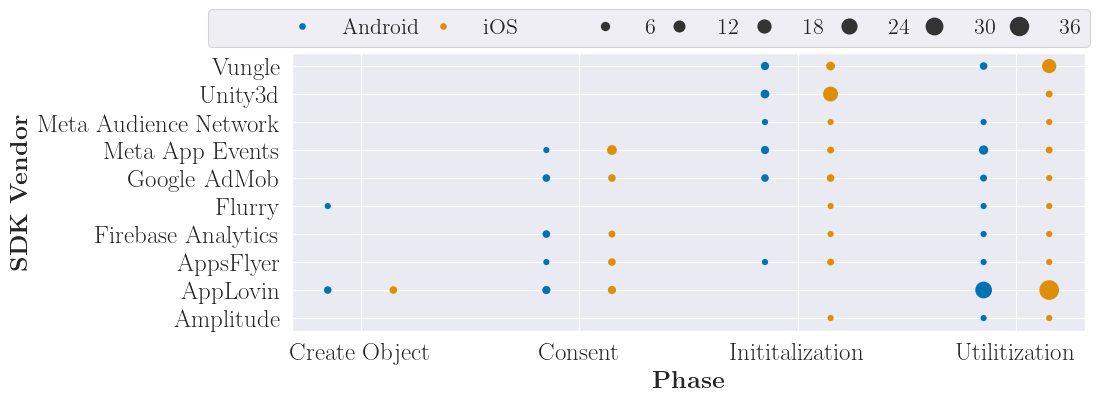

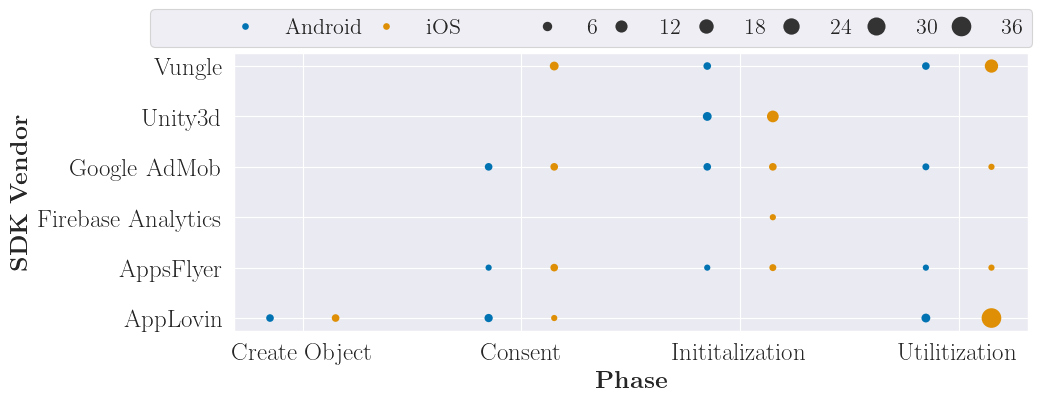

In [48]:
# this creates Figure 2
createScatterPlotRequests(consent_paired,"request_per_state.pdf")
# this creates the corresponding figure for requests during no consent
createScatterPlotRequests(noconsent_paired,"nocon_request_per_state.pdf")

In [51]:
# this function explains what request we weren't able to break
def getBadRequests(analysis):
    # 
    def getBad(phases, name, os):
        # go over the phases
        for phase, domains in phases.items():
            # go over the domains
            for domain, requests in domains["domains"].items():
                # go over the requests/paths
                for request, data in requests.items():
                    # if the overall amount of requests is larger than the successful ones we must have missed one
                    if data["overall"] > data["success"]:
                        # print that information
                        print(phase + " of " + name + " on " + os + " requesting " + domain )
    for name, pair in analysis.items():
        # get the handle for android measurements
        android = pair["Android"]
        # get the handle for iOS measurements
        ios = pair["iOS"]
        getBad(android, name, "Android")
        getBad(ios, name, "iOS")


        

In [49]:
# this answers the question which request in which phase didn't get successfully intercepted
getBadRequests(consent_paired)

BASIC_FUNC of Google AdMob on Android requesting googleads.g.doubleclick.net


In [52]:
# get the domains per phase for a given app analysis
def getDomainsPerPhase(analysis):
    # collect the domains for Android
    androidDomains = {}
    # collect the domains for iOS
    iosDomains = {}
    # go over all apps
    for name, pair in analysis.items():
        # handle for Android app analysis
        android = pair["Android"]
        # handle for iOS app analysis
        ios = pair["iOS"]
        # add the current app name to our android and iOS domain map
        if not name in androidDomains:
            androidDomains[name] = {}
            iosDomains[name] = {}
        # go over all phases in android
        for phase, domains in android.items():
            # ad the phase to our dictionaries keeping track of the domains
            if phase not in androidDomains[name]:
                androidDomains[name][phase] = set()
            # then start adding the observed domains
            for domain in domains["domains"].keys():
                androidDomains[name][phase].add(domain)
        # go over all phases in iOS
        for phase, domains in ios.items():
            # ad the phase to our dictionary keeping track of the domains
            if phase not in iosDomains[name]:
                iosDomains[name][phase] = set()
            # then start adding the observed domains
            for domain in domains["domains"].keys():
                iosDomains[name][phase].add(domain)
    # return the generated dictionaries
    return androidDomains, iosDomains

def getMismatchingDomains(analysis):
    # get the domains across each phase for android and iOS
    androidDomains, iosDomains = getDomainsPerPhase(analysis)
    # go over all domains and their phases
    for name, phases in androidDomains.items():
        print()
        print(name)
        iosSum = set()
        androidSum = set()
        for phase, android in phases.items():
             # we can ignore the NOTHING phase here as those requests are not part of our analysis
            if phase == "NOTHING":
                continue
            if phase == "BASIC_FUNC_INF":
                phase = "BASIC_FUNC"
            if not phase in iosDomains[name]: # this is a special measurement case where we had INF on both sides
                ios = iosDomains[name]["BASIC_FUNC_INF"]
            else:
                ios = iosDomains[name][phase]
            iosSum.update(ios)
            androidSum.update(android)
            iosDeltaAndroid = ios.difference(android)
            androidDeltaIos = android.difference(ios)
            if len(iosDeltaAndroid) > 0:
                print("iOS " + phase)
                print(iosDeltaAndroid)
            if len(androidDeltaIos) > 0:
                print("Android " + phase)
                print(androidDeltaIos)
        iosSumDeltaAndroid = iosSum.difference(androidSum)
        androidSumDeltaIos = androidSum.difference(iosSum)
        if len(iosSumDeltaAndroid) > 0:
            print("iOS sum delta")
            print(iosSumDeltaAndroid)
        if len(androidSumDeltaIos) > 0:
            print("Android sum delta")
            print(androidSumDeltaIos)
        print("android sum: " + str(len(androidSum)))
        print("ios sum: " + str(len(iosSum)))


def getMismatchingDomainsConsentNoConsent(consentPaired,noConsentPaired):
    ret = {}
    androidConDomains,iosConDomains = getDomainsPerPhase(consentPaired)
    androidNoconDomains, iosNoconDomains = getDomainsPerPhase(noConsentPaired)
    

In [50]:
# this provides the information for the last paragraph of 4.3.1
getMismatchingDomains(consent_paired)


Firebase Analytics
iOS INIT
{'firebaseinstallations.googleapis.com'}
Android CONSENT
{'firebaseinstallations.googleapis.com'}
android sum: 3
ios sum: 3

Meta Audience Network
iOS INIT
{'web.facebook.com'}
Android INIT
{'www.facebook.com'}
iOS sum delta
{'web.facebook.com'}
Android sum delta
{'www.facebook.com'}
android sum: 2
ios sum: 2

AppsFlyer
iOS CONSENT
{'gcgv3a-conversions.appsflyersdk.com', 'gcgv3a-attr.appsflyersdk.com', 'gcgv3a-dynamic-config-api.appsflyersdk.com'}
Android CONSENT
{'fjfock-conversions.appsflyersdk.com'}
iOS BASIC_FUNC
{'gcgv3a-inapps.appsflyersdk.com'}
Android BASIC_FUNC
{'fjfock-inapps.appsflyersdk.com'}
iOS INIT
{'gcgv3a-skadsdk.appsflyersdk.com', 'gcgv3a-cdn-settings.appsflyersdk.com'}
Android INIT
{'fjfock-cdn-settings.appsflyersdk.com'}
iOS sum delta
{'gcgv3a-dynamic-config-api.appsflyersdk.com', 'gcgv3a-conversions.appsflyersdk.com', 'gcgv3a-attr.appsflyersdk.com', 'gcgv3a-skadsdk.appsflyersdk.com', 'gcgv3a-inapps.appsflyersdk.com', 'gcgv3a-cdn-setting

In [17]:
getMismatchingDomains(noconsent_paired)


AppLovin
Android CONSENT
{'d.applovin.com', 'rt.applovin.com'}
iOS BASIC_FUNC
{'prod-mediate-events.applovin.com', 'impression.appsflyer.com', 'res1.applovin.com', 'app.adjust.com', 'assets.applovin.com', 'edge.safedk.com', 'img.applovin.com'}
iOS sum delta
{'prod-mediate-events.applovin.com', 'impression.appsflyer.com', 'res1.applovin.com', 'app.adjust.com', 'assets.applovin.com', 'edge.safedk.com', 'img.applovin.com'}
android sum: 4
ios sum: 11

Firebase Analytics
iOS INIT
{'firebaseinstallations.googleapis.com'}
iOS sum delta
{'firebaseinstallations.googleapis.com'}
android sum: 0
ios sum: 1

AppsFlyer
iOS INIT
{'gcgv3a-skadsdk.appsflyersdk.com', 'gcgv3a-cdn-settings.appsflyersdk.com'}
Android INIT
{'fjfock-cdn-settings.appsflyersdk.com'}
iOS CONSENT
{'gcgv3a-conversions.appsflyersdk.com', 'gcgv3a-attr.appsflyersdk.com', 'gcgv3a-dynamic-config-api.appsflyersdk.com'}
Android CONSENT
{'fjfock-conversions.appsflyersdk.com'}
iOS BASIC_FUNC
{'gcgv3a-inapps.appsflyersdk.com'}
Android BAS

In [53]:
# get all observed PII or rather data points
def getPIISet(analysis):
    ret = set()
    # go through all observed requests
    for app, adata in analysis.items():
        for state, sdata in adata.items():
            for DOMAINS, DOMAINSdata in sdata.items():
                for domain , ddata in DOMAINSdata.items():
                    for query, qdata in ddata.items():
                        for elem in qdata["pii"]:
                            # and add the PII to a set
                            ret.add(elem["PII"])
    # return the generated set
    return ret

In [54]:
# get all pii types
def getAllPiiTypes(analysis):
    # the set of all observed pii
    ret = set()
    # go through our analysis
    for app, adata in analysis.items():
        for state, sdata in adata.items():
            for domains, domainsdata in sdata.items():
                for domain, ddata in domainsdata.items():
                    for query, qdata in ddata.items():
                        for _, data in qdata.items():
                            for elem in data["pii"]:
                                # add the different pii to the set
                                ret.add(elem["PII"])
    # return the set
    return ret

In [55]:
def filterNonMissingPii(pii):
    #print(pii)
    ret = list()
    for elem in pii:
        if "#MISSING@" in elem["value"]:
            continue
        else:
            ret.append(elem["PII"])
    return ret

def filterIdentifier(pii_set):
    vendor = list()
    non_vendor = list()
    non_id = list()
    for pii in pii_set:
        if pii in {"ID_VENDOR_ADID"}:
            vendor.append(pii)
        elif pii in {"ID_OTHER","ID_UUID"}:
            non_vendor.append(pii)
        else:
            non_id.append(pii)
    return vendor, non_vendor, non_id

# this function analyzes the observed identifiers and 
def getIdentifierDistribution(analysis):
    endpoint_count = 0
    endpoint_receiving_id = 0
    identifiers = 0 # count all identifiers
    vendor_id = 0 # count vendor specific identifiers
    pii_with_identifier = list() # pii accompanied by identifiers
    # go through all apps
    for app, adata in analysis.items():
        for state, sdata in adata.items():
            for domains, domainsdata in sdata.items():
                for domain, ddata in domainsdata.items():
                    for query, qdata in ddata.items():
                        endpoint_count += 1  
                        for _, data in qdata.items():
                            vendor, non_vendor, non_id = filterIdentifier(filterNonMissingPii(data["pii"]))
                            if len(vendor) != 0 or len(non_vendor) != 0:
                                endpoint_receiving_id += 1
                                pii_with_identifier.append(len(non_id))
                            identifiers += len(vendor) + len(non_vendor)
                            vendor_id += len(vendor)
                            
    print(getNumbersMacro("pctEndpointsWithIdentifiers", endpoint_receiving_id / endpoint_count))
    avg = statistics.mean(pii_with_identifier)
    stdev = statistics.stdev(pii_with_identifier)
    print(getNumbersMacro("avgDataPointsWithIdentifiers", avg))
    print(getNumbersMacro("stdDevDataPointsWithIdentifiers", stdev))
    print(getNumbersMacro("pctOSIdentifiers", vendor_id / identifiers))

In [56]:
# provides the data for 4.3.2 last paragraph
getIdentifierDistribution(consent_paired)

\newcommand{\pctEndpointsWithIdentifiers}{\empirical{\num{0.9479166666666666}}}
\newcommand{\avgDataPointsWithIdentifiers}{\empirical{\num{8.428571428571429}}}
\newcommand{\stdDevDataPointsWithIdentifiers}{\empirical{\num{11.845433116365383}}}
\newcommand{\pctOSIdentifiers}{\empirical{\num{0.125}}}


In [57]:
# assign each pii to a group, this matches Table 4, escept for user agend, obfuscated, deobfuscated as we are still ignoring those datapoints
def assignGroup(pii):
    if pii in ["DEVICE_SPACE_FREE","DEVICE_SPACE_TOTAL","DEVICE_TOTAL_MEMORY","DEVICE_SPACE_EXTERNAL_TOTAL","DEVICE_FREE_MEMORY","DEVICE_SPACE_INTERNAL_FREE","DEVICE_SPACE_EXTERNAL_FREE","DEVICE_SPACE_INTERNAL_TOTAL"] :
        return "Storage and Memory"
    elif pii in ["DEVICE_MAKER","DEVICE_OS_TYPE","SYSTEM_BOOT_TIME","DEVICE_BATTERY_STATUS","DEVICE_OS_API_LEVEL","DEVICE_VOLUME","DEVICE_BATTERY_LEVEL","DEVICE_ELAPSED_TIME","DEVICE_OS_ROOTED","DEVICE_STORES","DEVICE_UPTIME","DEVICE_OS_VERSION"]:
        return "Meta Data"
    elif pii in ["DEVICE_SCREEN_HEIGHT","DEVICE_SCREEN_BRIGHTNESS","DEVICE_SCREEN_SIZE","DEVICE_SCREEN_DENSITY","DEVICE_SCREEN_LAYOUT","DEVICE_SCREEN_WIDTH"]:
        return "Display"
    elif pii in ["APP_VERSION","APP_ID"]:
        return "App Data"
    elif pii in ["IP_LOCAL_GATEWAY","DEVICE_NETWORK_CONNECTION_TYPE","DEVICE_NETWORK_OPERATOR"]:
        return "Network"
    elif pii in ["ID_GLOBAL_ADID","DEVICE_NAME","ID_UUID","ID_OTHER","ID_VENDOR_ADID"]:
        return "Identifier"
    elif pii == "USER_AGEND":
        return "User Agent"
    elif pii in ["DEVICE_HEADSET","DEVICE_MODEL","DEVICE_CPU","DEVICE_IS_SIMULATOR"]:
        return "Hardware"
    elif pii in ["DEVICE_LANGUAGE","TIME_ZONE","COUNTRY"]:
        return "Locale"
    elif pii in ["DEVICE_ROTATION_X","DEVICE_ROTATION_Y","DEVICE_ROTATION_Z"]:
        return "Positioning"
    elif pii in ["LONGITUDE","LATITUDE"]:
        return "Location"
    elif pii in ["DEVICE_ACCELEROMETER_X","DEVICE_ACCELEROMETER_Y","DEVICE_ACCELEROMETER_Z"]:
        return "Movement"
    elif pii in ["IAB_STRING"]:
        return "IAB String"
    elif pii in ["OBFUSCATED","DEOBFUSCATED"]:
        return "Obfuscation"
    else:
        raise Exception("I do not have a group for " + pii)

def getPIISet(analysis, grouped=True):
    ret = set()
    for app, adata in analysis.items():
        for state, sdata in adata.items():
            for DOMAINS, DOMAINSdata in sdata.items():
                for domain , ddata in DOMAINSdata.items():
                    for query, qdata in ddata.items():
                        for elem in qdata["pii"]:
                            if grouped:
                                ret.add(assignGroup(elem["PII"]))
                            else:
                                ret.add(elem["PII"])
    return ret

# this helper function translates the phases into integers for easier plotting
def translatePhase(phase):
    if phase == "INIT":
        return "3"
    if phase == "CONSENT":
        return "2"
    if phase == "BASIC_FUNC" or phase == "BASIC_FUNC_INF":
        return "4"
    if phase == "CREATE_OBJECT":
        return "1"
    print(phase)
    raise "WHAT THE ..." # shouldn't happen and is simply a sanity check to ensure it doesn't

def createScatterPlotPiiPie(analysis,fileName, sizex, sizey, grouped=True, ignoreSdk=[]):
    # dict to collect all involved companies
    companies = {}

    # go through our raw, i.e., not paired data set
    for app, phaseData in analysis.items():
        # translate the app into company and operating system
        company, os, _ = translateAppName(app)
        # if we want to ignore the company
        if company in ignoreSdk:
            continue

        # if the company is not yet contained
        if not company in companies:
            # add the company
            companies[company] = {os : {}}
        if not os in companies[company]:
            # if the OS is not yet defined for that company add the os key
            companies[company][os] = {}
            
        # go through all phases
        for phase, domainData in phaseData.items():
            # ignore the NOTHING phase
            if phase == "NOTHING":
                continue
            # translate the phase using our helper function
            phase = translatePhase(phase)
            # go through all domains
            for domain, pathData in domainData.items():
                # go through all paths
                for path, subdata in pathData.items():
                    for _, data in subdata.items():
                        # go through all observed piis
                        for pii in data["pii"]:
                            # ensure that even if we filtered that we do not include empty or missing PII - doube check
                            if not ("#MISSING@" in pii["value"] and not pii["value"].strip() == ""):
                                # get the pii group name if we want to plot grouped otherwise use the name directly
                                piiName = assignGroup(pii["PII"]) if grouped else pii["PII"]
                                # if the current company and os does not yet have that pii add it
                                if not piiName in companies[company][os]:
                                    companies[company][os][piiName] = set()
                                # add the phase in which we observed that pii to our dictionary entry
                                companies[company][os][piiName].add(phase)
    # get a sorted list of all piis, later on used for indexing
    piiList = sorted(list(getPIISet(analysis)))
    # get a list of all companies, later on used for indexing
    companyNames = list(companies.keys())
    # the x coordinates to be plotted
    plotX = list()
    # the y coordinates to be plotted
    plotY = list()
    # the hue for the dot to be plotted, i.e., the operating system
    hue = list()
    # admittedly badly named but this is the phase for which the dot is to be made, i.e., the symbol to use
    size = list()
    # the size of the dot, we only use this to be able to play around with different sizes for legibility
    actualSize = list()
    # the marker to be used for the dot
    marker = list()
    
    # go over all companies in our company data dictionary previoulsy generated above
    for company, osData in companies.items():
        # get the plotting index for the company
        companyCount = companyNames.index(company)
        # go over all overseved pii and their phases in android
        for name,location in osData["Android"].items():
            # go over all locations
            for loc in location:
                # we are using size ten as that is legible
                actualSize.append(10)
                # go over each location and assign the correct names, symbols, and positions for later plotting
                if loc == "1":
                    plotX.append(companyCount - 0.31)
                    plotY.append(piiList.index(name))
                    hue.append("Android")
                    size.append("Create Object")
                    marker.append("o")
                if loc == "2":
                    plotX.append(companyCount - 0.24)
                    plotY.append(piiList.index(name))
                    hue.append("Android")
                    size.append("Consent")
                    marker.append("s")
                if loc == "3":
                    plotX.append(companyCount - 0.17)
                    plotY.append(piiList.index(name))
                    hue.append("Android")
                    size.append("Initialize")
                    marker.append("p")
                if loc == "4":
                    plotX.append(companyCount - 0.10)
                    plotY.append(piiList.index(name))
                    hue.append("Android")
                    size.append("Functionality")
                    marker.append("X")
        # go over all observed pii and their phases in iOS
        for name,location in osData["iOS"].items():
            # go over all locations
            for loc in location:
                # we are using size ten as that is legible
                actualSize.append(10)
                # go over each location and assign the correct names, symbols, and positions for later plotting
                if loc == "1":
                    plotX.append(companyCount + 0.10)
                    plotY.append(piiList.index(name))
                    hue.append("iOS")
                    size.append("Create Object")
                    marker.append("o")
                if loc == "2":
                    plotX.append(companyCount + 0.17)
                    plotY.append(piiList.index(name))
                    hue.append("iOS")
                    size.append("Consent")
                    marker.append("s")
                if loc == "3":
                    plotX.append(companyCount + 0.24)
                    plotY.append(piiList.index(name))
                    hue.append("iOS")
                    size.append("Initialize")
                    marker.append("p")
                if loc == "4":
                    plotX.append(companyCount + 0.31)
                    plotY.append(piiList.index(name))
                    hue.append("iOS")
                    size.append("Functionality")
                    marker.append("X")

    # create a data dictionary for seaborn
    data={
        "x" : plotX, # the x coordinates
        "y" : plotY, # the y coordinates
        "Platform" : hue, # the hue, i.e., platform 
        "Phase" : size, # the phase they belong to
        "actualSize" : actualSize, # this one isn't used anymore
        "markers" : marker # this one isn't used anymore
    }
    # remeber the size for markers
    oldSize =  plt.rcParams['lines.markersize']
    # change the size for markers
    plt.rcParams['lines.markersize'] = 8 
    # the markers we want to use
    markers=["o","s","d","X"]
    # create a subplot to control layout, size, and legend
    fig, ax = plt.subplots(figsize=[sizex*default_figsize_x, sizey*default_figsize_y])
    # create the scatterplot using seaborn
    sns.scatterplot(x="x", y="y", hue="Platform", hue_order=['Android', 'iOS'],
                    style="Phase",
                    ax=ax, sizes=(20,300), data=data, legend= True, markers=markers)
    # set the y ticks
    ax.set_yticks(range(0,len(piiList)))
    # create a list of y tickes, depending on grouping or no grouping beautify them
    beautifulYTicks = list()
    for tick in piiList:
        if grouped:
            beautifulYTicks.append(tick)
        else:
            beautifulYTicks.append(tick.replace("_"," ").lower())
    # set those y ticks
    ax.set_yticklabels(beautifulYTicks)
    # set the x ticks
    ax.set_xticks(range(0,len(companies)))
    # to the companies
    ax.set_xticklabels(companies)
    # create the x and y axis labels
    ax.set_xlabel('SDK Vendor')
    ax.set_ylabel('Data Points')
    # move the legend to a better position
    sns.move_legend(ax, loc='lower left', ncol=8,bbox_to_anchor=(-0.0, 1.0))
    # change the size of the markers back to do not cause any side effects
    plt.rcParams['lines.markersize'] = oldSize 
    # store the figure
    fig.savefig(fileName, bbox_inches="tight", pad_inches=0)   

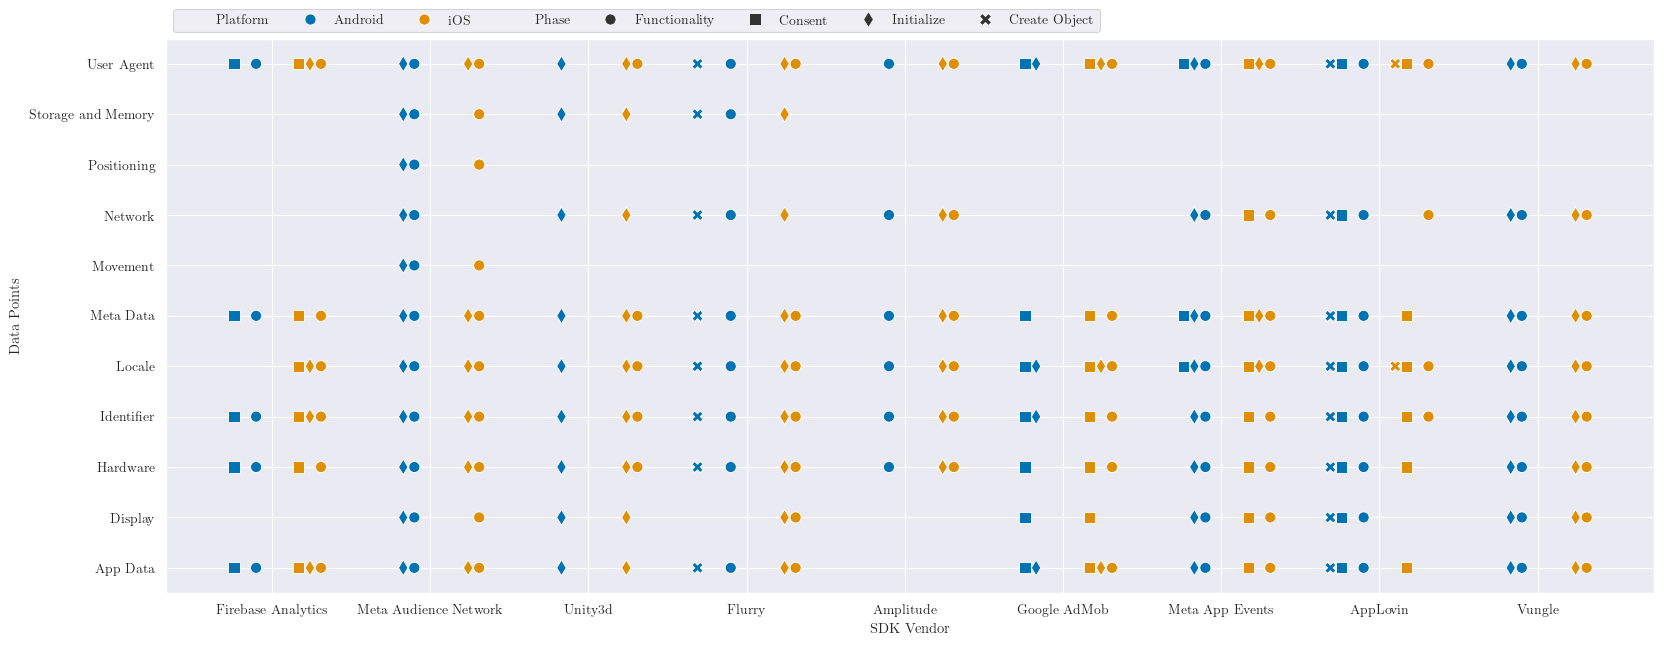

In [58]:
json = filterResults(readJson("./consent.json"))
createScatterPlotPiiPie(json["appAnalysis"],"data_transmissions.pdf",3.0,1.5,grouped=True,ignoreSdk=["AppsFlyer",]) # we ignore AppsFlyer as we cannot break their obfuscation

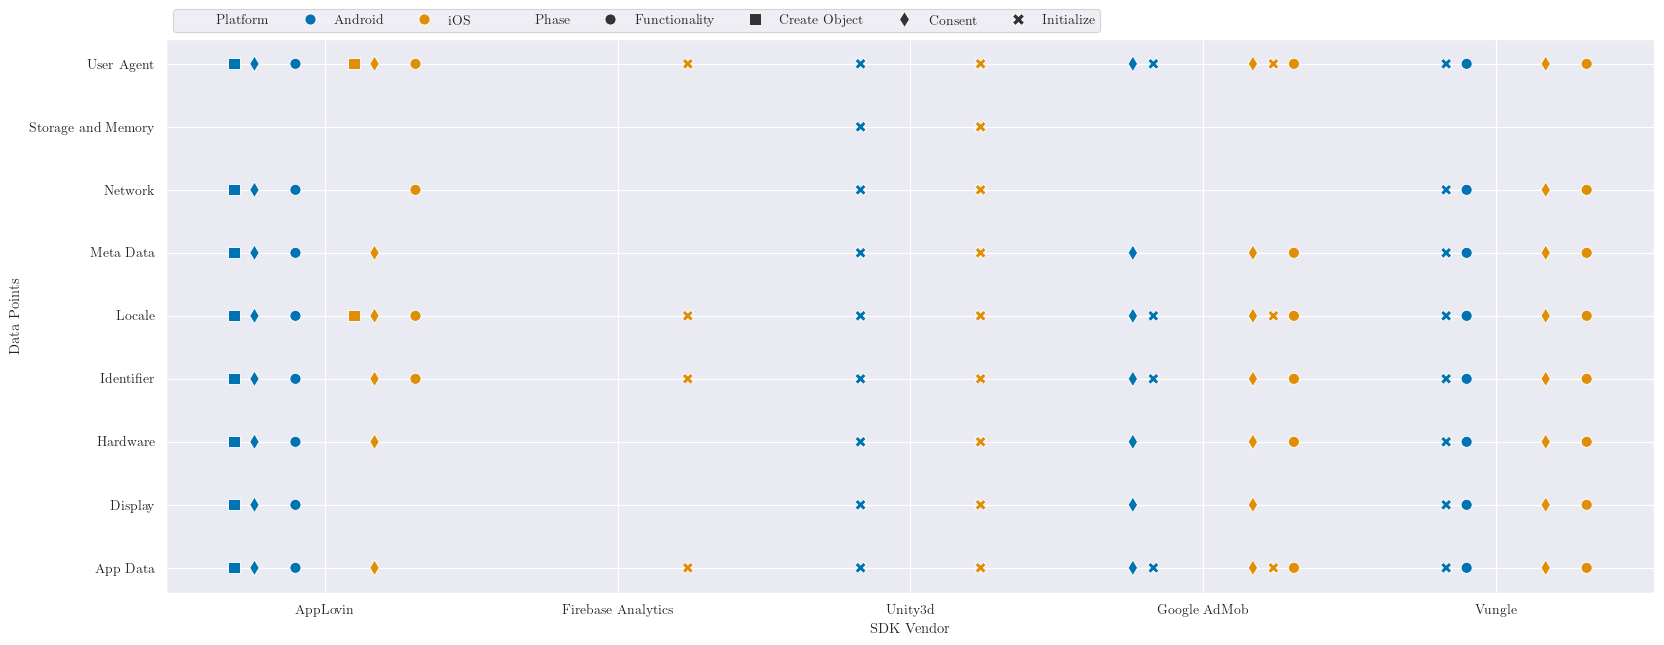

In [59]:
jsonnocon = filterResults(readJson("./noconsent.json"))
createScatterPlotPiiPie(jsonnocon["appAnalysis"],"data_transmissions_nocon.pdf",3.0,1.5,ignoreSdk=["AppsFlyer"]) # we ignore AppsFlyer as we cannot break their obfuscation

In [60]:
# this function summarizes the transmissions per phase
def transmissionsPerPhase(analysis, grouped=True):
    # we want to do this for each OS as well as across sdks
    sdk = {
        "Android" : {}, 
        "IOS" : {}
    }
    # go over all apps
    for name, pair in analysis.items():
        # handle for android
        android = pair["Android"]
        # handle for iOS
        ios = pair["iOS"]
        # create our raw dictionary covering the phases and for each phases keeps a set of observed values and observed types
        sdk["Android"][name] = {"CREATE_OBJECT" : {"values" : set(), "types" : set() } ,"CONSENT" : {"values" : set(), "types" : set() },"INIT" : {"values" : set(), "types" : set() },"BASIC_FUNC" : {"values" : set(), "types" : set() }, "merge" : {"values" : set(), "types" : set() }}
        sdk["IOS"][name]     = {"CREATE_OBJECT" : {"values" : set(), "types" : set() }, "CONSENT" : {"values" : set(), "types" : set() },"INIT" : {"values" : set(), "types" : set() },"BASIC_FUNC" : {"values" : set(), "types" : set() }, "merge" : {"values" : set(), "types" : set() }}
        # go over all phases for android
        for phase, domains in android.items():
            # as usual ignore the NOTHING phase
            if phase == "NOTHING":
                continue
            # merge BASIC_FUNC_INF and BASIC_FUNC
            if phase == "BASIC_FUNC_INF":
                phase = "BASIC_FUNC"
            # go over all domains
            for domain, req in domains["domains"].items():
                # go over all requests
                for path, data in req.items():
                    # go over all observed data points
                    for pii in data["pii"]:
                        # ensure that we are not counting anything missing, again this is supposed to be a double check as we are working on a filtered data set
                        if not ("#MISSING@" in pii["value"] and not pii["value"].strip() == ""):
                            # add the value of the pii to the dictionary
                            sdk["Android"][name][phase]["values"].add(pii["value"])
                            # also keep track of all observed values
                            sdk["Android"][name]["merge"]["values"].add(pii["value"])
                            # add the type of the pii to our dictionary (either grouped or raw)
                            sdk["Android"][name][phase]["types"].add(assignGroup(pii["PII"]) if grouped else pii["PII"])
                            # also keep track of all observed pii (either grouped or raw)
                            sdk["Android"][name]["merge"]["types"].add(assignGroup(pii["PII"]) if grouped else pii["PII"])
        # go over all phases for ios
        for phase, domains in ios.items():
            if phase == "NOTHING":
                continue
            # merge BASIC_FUNC_INF and BASIC_FUNC
            if phase == "BASIC_FUNC_INF":
                phase = "BASIC_FUNC"
            # go over all domains
            for domain, req in domains["domains"].items():
                # go over all requests
                for path, data in req.items():
                    # go over all observed data points
                    for pii in data["pii"]:
                        # ensure that we are not counting anything missing, again this is supposed to be a double check as we are working on a filtered data set
                        if not ("#MISSING@" in pii["value"] and not pii["value"].strip() == ""):
                            # add the value of the pii to the dictionary
                            sdk["IOS"][name][phase]["values"].add(pii["value"])
                            # also keep track of all observed values
                            sdk["IOS"][name]["merge"]["values"].add(pii["value"])
                            # add the type of the pii to our dictionary (either grouped or raw)
                            sdk["IOS"][name][phase]["types"].add(assignGroup(pii["PII"]) if grouped else pii["PII"])
                            # also keep track of all observed pii (either grouped or raw)
                            sdk["IOS"][name]["merge"]["types"].add(assignGroup(pii["PII"]) if grouped else pii["PII"])
    # go over all SDKs in Android (given that Android and iOS are mirrored we won't miss any iOS here)
    for name, phases in sdk["Android"].items():
        # merge BASIC_FUNC_INF and BASIC FUNC (shouldn´t be required
        for phase in phases.keys():
            if phase == "BASIC_FUNC_INF":
                phase = "BASIC_FUNC"
            # start printing the meta data we just calculated
            piiSetAndroid = sdk["Android"][name][phase]["values"]
            typeSetAndroid = sdk["Android"][name][phase]["types"]
            piiSetIOS = sdk["IOS"][name][phase]["values"]
            typeSetIOS = sdk["IOS"][name][phase]["types"]
            deltaAndroid = len(typeSetAndroid.difference(typeSetIOS))
            deltaIOS = len(typeSetIOS.difference(typeSetAndroid))
            displayCommand("amountData" + phase.replace("_","") + name.replace(" ","").replace("3d","") + "Android", len(piiSetAndroid))
            displayCommand("amountData" + phase.replace("_","") + name.replace(" ","").replace("3d","") + "IOS", len(piiSetIOS))
            displayCommand("amountData" + phase.replace("_","") + name.replace(" ","").replace("3d","") + "Delta", deltaIOS + deltaAndroid)

In [61]:
#generates the numbers for Table 6
transmissionsPerPhase(consent_paired)

\newcommand{\amountDataCREATEOBJECTFirebaseAnalyticsAndroid}{0}
\newcommand{\amountDataCREATEOBJECTFirebaseAnalyticsIOS}{0}
\newcommand{\amountDataCREATEOBJECTFirebaseAnalyticsDelta}{0}
\newcommand{\amountDataCONSENTFirebaseAnalyticsAndroid}{8}
\newcommand{\amountDataCONSENTFirebaseAnalyticsIOS}{9}
\newcommand{\amountDataCONSENTFirebaseAnalyticsDelta}{1}
\newcommand{\amountDataINITFirebaseAnalyticsAndroid}{0}
\newcommand{\amountDataINITFirebaseAnalyticsIOS}{4}
\newcommand{\amountDataINITFirebaseAnalyticsDelta}{4}
\newcommand{\amountDataBASICFUNCFirebaseAnalyticsAndroid}{7}
\newcommand{\amountDataBASICFUNCFirebaseAnalyticsIOS}{9}
\newcommand{\amountDataBASICFUNCFirebaseAnalyticsDelta}{1}
\newcommand{\amountDatamergeFirebaseAnalyticsAndroid}{9}
\newcommand{\amountDatamergeFirebaseAnalyticsIOS}{10}
\newcommand{\amountDatamergeFirebaseAnalyticsDelta}{1}
\newcommand{\amountDataCREATEOBJECTMetaAudienceNetworkAndroid}{0}
\newcommand{\amountDataCREATEOBJECTMetaAudienceNetworkIOS}{0}
\newcomman

In [62]:
# this function returns the amount of observed obfuscated requests
def countObfuscatedRequests(analysis):
    # dictionary for legibility
    ret = {}
    # go over all apps
    for name, phases in analysis.items():
        appName , _, _ = translateAppName(name)
        if not appName in ["AppsFlyer","AppLovin"]: # only AppsFlyer and AppLovin had obfuscated requests
            continue
        # if the name of the app is not a key add it
        if not name in ret:
            ret[name] = {}
        # go over all phases
        for phase, domains in phases.items():
            # add the phase to the dictionary
            if not phase in ret[name]:
                ret[name][phase] = {"ob" : 0, "deob" : 0}
            # go over all domains
            for domain, req in domains["domains"].items():
                # go over all endpoints
                for path, data in req.items():
                    # go over all observed pii
                    for pii in data["pii"]:
                        # if the enppoint received an obfuscated and not missing value increment the entry in the dictionary
                        if pii["PII"] == "OBFUSCATED" and not ("#MISSING@" in pii["value"] and not pii["value"].strip() == ""):
                            ret[name][phase]["ob"] += 1
                        # if the endpoint received an obfuscated and not missing value increment the entry in the dictionary
                        if pii["PII"] == "DEOBFUSCATED" and not ("#MISSING@" in pii["value"] and not pii["value"].strip() == ""):
                            ret[name][phase]["deob"] += 1
    return ret

In [63]:
# we have to work on the unfiltered list as we actually want to consider the obfuscated and deobfuscated values
obfus = readJson("./consent.json")
# this generates the numbers reported in 4.3.3
countObfuscatedRequests(obfus["appAnalysis"])

{'MeaCulpa.AFiOS:NA@ios': {'CREATE_OBJECT': {'ob': 0, 'deob': 0},
  'INIT': {'ob': 0, 'deob': 0},
  'CONSENT': {'ob': 2, 'deob': 0},
  'BASIC_FUNC': {'ob': 1, 'deob': 0}},
 'de.tubs.cs.ias.fly:NA@android': {'CONSENT': {'ob': 1, 'deob': 0},
  'BASIC_FUNC': {'ob': 1, 'deob': 0},
  'CREATE_OBJECT': {'ob': 0, 'deob': 0},
  'INIT': {'ob': 0, 'deob': 0}},
 'de.tubs.cs.ias.AppLovinTest:NA@ios': {'CREATE_OBJECT': {'ob': 6, 'deob': 0},
  'CONSENT': {'ob': 6, 'deob': 0},
  'INIT': {'ob': 0, 'deob': 0},
  'BASIC_FUNC': {'ob': 34, 'deob': 0}},
 'de.tubs.cs.ias.applovin:NA@android': {'CREATE_OBJECT': {'ob': 0, 'deob': 6},
  'CONSENT': {'ob': 0, 'deob': 6},
  'INIT': {'ob': 0, 'deob': 0},
  'BASIC_FUNC': {'ob': 21, 'deob': 5}}}